# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

*Описание данных*
 
Признаки:
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
Repaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя


Целевой признак:
Price — цена (евро)

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

### Загрузка и изучение данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
def data_info(df):
    print("Первые 5 строк датафрейма")
    display(df.head())
    print()
    print("Информация о датафрейме")
    print(df.info())
    print()
    print("Тип данных в каждом столбце датафрейма")
    print(df.dtypes)
    print()
    print("Количество пропусков в каждом столбце датафрейма")
    print(df.isna().sum())
    print("Доля пропусков в каждом столбце датафрейма")
    print(df.isna().mean()*100)
    print()
    print("Количество явных дубликатов")
    print(df.duplicated().sum())

In [4]:
data_info(data)

Первые 5 строк датафрейма


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object


**Вывод:** Данные успешно выгружены, в них есть пропущенные значения и явные дубликаты. 

### Предобработка данных

#### Приведение названия столбцов к нужному виду

In [5]:
data.columns = data.columns.str.lower()
data.rename(columns = {
    'datecrawled': 'date_crawled', 'vehicletype': 'vehicle_type', 'registrationyear':'registration_year',
    'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 'datecreated': 'date_created',
    'numberofpictures': 'number_of_pictures', 'postalcode': 'postal_code', 'lastseen': 'last_seen'
}, inplace = True )
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Приобразование столбцов с датами в формат дат

In [6]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%dT%H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%dT%H:%M:%S')

#### Удаление пропусков 

Заполним пропущенные значения в столбцах тип автомобильного кузова, модель и тип топлива категорией 'other', пропуски в столбцах тип коробки передач и была ли машина в ремонте удалим, т.к. нет возможности восстановить данные.

In [7]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['model'] = data['model'].fillna('other')
data['fuel_type'] = data['fuel_type'].fillna('other')
data = data.dropna()

#### Удаление явных дубликатов

In [8]:
data = data.drop_duplicates()

#### Удаление неявных дубликатов

In [9]:
data['model'] = data['model'].str.replace('rangerover', 'range_rover')

#### Распределение количественных данных

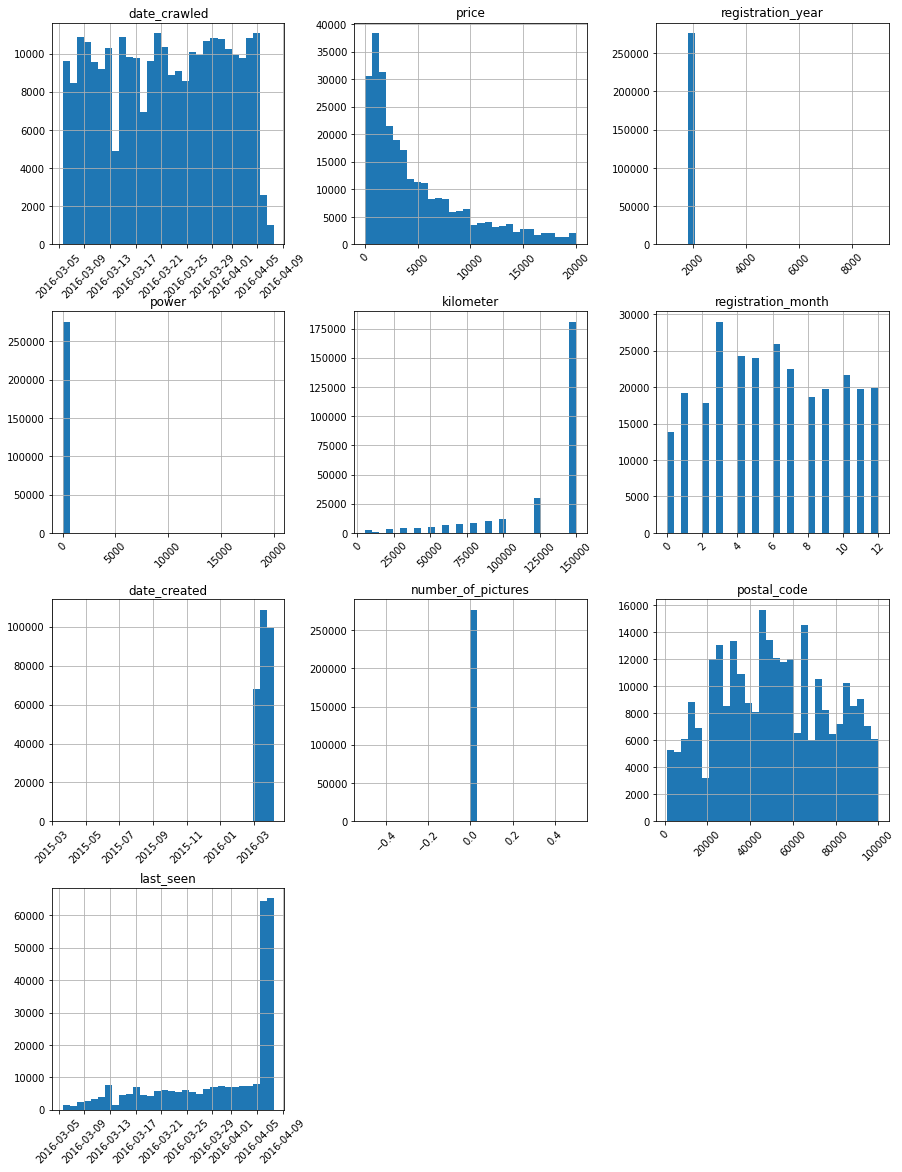

In [10]:
data.hist(figsize=(15, 20), bins = 30, xrot=45);
plt.show()


#### Удаление аномалий в данных

In [11]:
data = data.query('price>400') #оставим цены выше 400 евро

In [12]:
data = data.query('power>40 and power<1000') #предположим, что мощность может быть в среднем от 40 до 1000 л.с.

In [13]:
data = data.query('registration_year<2017') #ограничим год регистрации до 2016 года по дате скачивания анкеты

**Вывод:** В данных обработаны пропуски и дубликаты, также выявлены анамольные значения: в столбце цены удалили значения ниже 400 евро, в столбце мощности автомобилей оставили значения от 40 до 1000 л.с., ограничили год регистрации до 2016 года по дате скачивания анкеты.

### Корреляция признаков и удаление неинформативных признаков

In [14]:
data.corr()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.513579,0.492546,-0.406607,0.036977,NaN,0.057203
registration_year,0.513579,1.000000,0.102140,-0.352900,0.020985,NaN,0.022041
power,0.492546,0.102140,1.000000,0.116836,0.024956,NaN,0.047433
kilometer,-0.406607,-0.352900,0.116836,1.000000,-0.006387,NaN,-0.010165
registration_month,0.036977,0.020985,0.024956,-0.006387,1.000000,NaN,0.000417
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.057203,0.022041,0.047433,-0.010165,0.000417,NaN,1.000000


In [15]:
data_new = data.drop([
    'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 
    'postal_code', 'last_seen'
], axis=1)

**Вывод:** Наиболее сильная корреляция с целевой переменной у признаков "мощность" и "год регистрации" и обратная у признака "пробег", мультиколлинеарность факторов не обнаружена. Удалены неинформативные признаки: дата скачивания анкеты, месяц регистрации, дата создания анкеты, количество фотографий, индекс и дата последней активности пользователя.

**Общий вывод:** Данные успешно выгружены, в них выявлены и заполнены пропущенные значения, удалены дубликаты. Также обработаны аномалии в столбцах цены и мощности, удалены неинформативные признаки.

## Обучение моделей

### Подготовка выборки для обучения моделей

In [16]:
target = data_new['price']
features = data_new.drop('price', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(144434, 9)
(48145, 9)
(48145, 9)
(144434,)
(48145,)
(48145,)


### Кодирование данных

In [17]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

### Масштабирование данных

In [18]:
numeric = ['power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_166/1300999805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric] = scaler.transform(features_valid[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [19]:
RANDOM_STATE = 12345

### Модель LogisticRegression

RMSE = 5972.58942609269

CPU times: user 11min 19s, sys: 6min 43s, total: 18min 3s

Wall time: 18min 4s

### Модель DecisionTreeRegressor

In [20]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

RMSE для лучшей модели: 3701.0958346902653 Максимальная глубина: 19

CPU times: user 4.56 s, sys: 41.3 ms, total: 4.6 s

Wall time: 4.6 s

### Модель RandomForestRegressor

RMSE для лучшей модели: 2428.93356423896 n_estimators=: 20 max_depth= 5

CPU times: user 7min 26s, sys: 3.7 s, total: 7min 30s

Wall time: 7min 30s

### Модель LGBMRegressor

In [21]:
features_train_new = features_train.copy()
features_valid_new = features_valid.copy()
features_test_new = features_test.copy()

features_train_new[cat_columns] = features_train_new[cat_columns].astype('category')
features_valid_new[cat_columns] = features_valid_new[cat_columns].astype('category')
features_test_new[cat_columns] = features_test_new[cat_columns].astype('category')

RMSE для лучшей модели: 1681.2567723500497 num_iterations= 50 max_depth= 5

CPU times: user 46min 19s, sys: 43.4 s, total: 47min 2s

Wall time: 47min 21s

### Модель CatBoostRegressor

RMSE для лучшей модели: 1739.672288346819 iterations= 50 max_depth= 5

CPU times: user 16min 13s, sys: 1min 58s, total: 18min 12s

Wall time: 18min 56s

**Вывод:** Обучены несколько моделей: линейная регрессия, дерево решений, случайный лес, LightGBM и CatBoost. Лучшие результаты по точности и времени работы показали модели: RandomForestRegressor (с гиперпараметрами: n_estimators=: 20 max_depth= 5): RMSE = 2429, градиентного бустинга LightGBM (с гиперпараметрами: num_iterations= 50 max_depth= 5): RMSE = 1833 и CatBoost (с гиперпараметрами: iterations= 50 max_depth= 5): RMSE = 1768.

## Анализ моделей

Возьмем лучшие модели RandomForestRegressor, LightGBM и CatBoost и проанализируем время обучения и время предсказания, чтобы выбрать самую подходящую для заказчика.

### Анализ модели  RandomForestRegressor

#### Время обучения модели  RandomForestRegressor

In [22]:
%%time
model_forest = RandomForestRegressor(n_estimators=20, max_depth= 5, random_state=RANDOM_STATE) 
model_forest.fit(features_train_ord, target_train)


CPU times: user 2.55 s, sys: 11.2 ms, total: 2.57 s
Wall time: 2.58 s


RandomForestRegressor(max_depth=5, n_estimators=20, random_state=12345)

#### Время предсказания модели RandomForestRegressor

In [23]:
%%time
predicted_valid = model_forest.predict(features_valid_ord)

CPU times: user 46.6 ms, sys: 263 µs, total: 46.9 ms
Wall time: 45.2 ms


#### RMSE вычисляется на валидационной выборке

In [24]:
rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
print("RMSE модели RandomForestRegressor:", rmse)

RMSE модели RandomForestRegressor: 2428.93356423896


In [25]:
#результаты 1й модели
time_train_1 = '2.34 s' #время обучения модели
time_pred_1 = '50.3 ms'#время предсказания модели
RMSE_1 = 2429

### Анализ модели  LightGBM

#### Время обучения модели  LightGBM

In [26]:
%%time
model_lgbmr = LGBMRegressor(metric='RMSE', num_iterations= 50, max_depth= 5, random_state=RANDOM_STATE) 
model_lgbmr.fit(features_train_new, target_train)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 50.6 s, sys: 355 ms, total: 50.9 s
Wall time: 51.1 s


LGBMRegressor(max_depth=5, metric='RMSE', num_iterations=50, random_state=12345)

#### Время предсказания модели  LightGBM

In [27]:
%%time
predicted_valid = model_lgbmr.predict(features_valid_new)

CPU times: user 244 ms, sys: 2.47 ms, total: 246 ms
Wall time: 200 ms


#### RMSE вычисляется на валидационной выборке

In [28]:
rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
print("RMSE модели LightGBM =", rmse)

RMSE модели LightGBM = 1681.2567723500497


In [29]:
#результаты 2й модели
time_train_2 = '1min 10s' #время обучения модели
time_pred_2 = '273 ms'#время предсказания модели
RMSE_2 = 1681

### Анализ модели  CatBoost

#### Время обучения модели  CatBoost

In [30]:
%%time
model_catboost = CatBoostRegressor(loss_function='RMSE', iterations= 50, max_depth= 5, random_state=RANDOM_STATE)
model_catboost.fit(features_train, target_train, cat_features=cat_columns)

Learning rate set to 0.5
0:	learn: 3368.8249395	total: 104ms	remaining: 5.07s
1:	learn: 2791.9717450	total: 159ms	remaining: 3.83s
2:	learn: 2514.6204041	total: 218ms	remaining: 3.41s
3:	learn: 2278.0286680	total: 262ms	remaining: 3.01s
4:	learn: 2177.6856112	total: 300ms	remaining: 2.7s
5:	learn: 2109.6790962	total: 347ms	remaining: 2.54s
6:	learn: 2067.0549561	total: 387ms	remaining: 2.38s
7:	learn: 2032.7135057	total: 447ms	remaining: 2.35s
8:	learn: 2002.7826117	total: 494ms	remaining: 2.25s
9:	learn: 1980.9815016	total: 538ms	remaining: 2.15s
10:	learn: 1959.0669201	total: 578ms	remaining: 2.05s
11:	learn: 1944.6856152	total: 625ms	remaining: 1.98s
12:	learn: 1930.3980337	total: 665ms	remaining: 1.89s
13:	learn: 1918.3681203	total: 704ms	remaining: 1.81s
14:	learn: 1906.0406375	total: 744ms	remaining: 1.74s
15:	learn: 1895.8456450	total: 784ms	remaining: 1.67s
16:	learn: 1888.2915613	total: 831ms	remaining: 1.61s
17:	learn: 1880.8891467	total: 870ms	remaining: 1.55s
18:	learn: 187

#### Время предсказания модели  CatBoost

In [31]:
%%time
predicted_valid = model_catboost.predict(features_valid)

CPU times: user 63.6 ms, sys: 3.9 ms, total: 67.5 ms
Wall time: 67.1 ms


#### RMSE вычисляется на валидационной выборке

In [32]:
rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
print("RMSE модели CatBoost =", rmse)

RMSE модели CatBoost = 1739.672288346819


In [33]:
#результаты 3й модели
time_train_3 = '3.61 s' #время обучения модели
time_pred_3 = '86.1 ms'#время предсказания модели
RMSE_3 = 1740

###  Проверьте модели на адекватность

In [34]:
dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(features_train, target_train)
dummy_predictions = dummy_clf.predict(features_test)
rmse = mean_squared_error(target_test, dummy_predictions) ** 0.5
print("RMSE для модели дамми:", rmse)

RMSE для модели дамми: 4699.360102407339


###  Результаты анализа моделей

In [37]:
df = pd.DataFrame({
    'time_train':['2.58 s', '51.1 s', '3.37 s'],
    'time_pred':['45.2 ms', '200 ms', '67.1 ms'],
    'RMSE': [RMSE_1, RMSE_2, RMSE_3]}, index=['RandomForestRegressor', 'LightGBM', 'CatBoost']
)
df

,time_train,time_pred,RMSE
RandomForestRegressor,2.58 s,45.2 ms,2429
LightGBM,51.1 s,200 ms,1681
CatBoost,3.37 s,67.1 ms,1740


**Вывод:** Проанализированы время работы модели: RandomForestRegressor (с гиперпараметрами: n_estimators=: 20 max_depth= 5), градиентного бустинга LightGBM (с гиперпараметрами: num_iterations= 50 max_depth= 5) и CatBoost (с гиперпараметрами: iterations= 50 max_depth= 5). 
Лучший результат по точности показала модель LightGBM, но время на обучение и предсказания затрачено меньше у модели CatBoost. Так как заказчику важны как критерии качества, так и времени, то целесообразно выбрать модель CatBoost (точность прогноза ниже примерно на 4%).


## Тестирование лучшей модели

In [38]:
predicted_test = model_catboost.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test) ** 0.5
print("RMSE на тестовой выборки лучшей модели:", rmse)

RMSE на тестовой выборки лучшей модели: 1743.1995144971168


**Вывод:** Выбрана модель градиентного бустинга CatBoost (с гиперпараметрами num_iterations= 50 max_depth= 5), RMSE на тестовой выборки составил 1743.

## Вывод

***Общий вывод:***

Проведено исследование данных для сервиса по продаже автомобилей с пробегом с целью построения модели, которая будет уметь определять рыночную стоимость своего автомобиля.

В результате анализа обнаружены и обработаны пропуски в данных, удалены дубликаты и аномальные значения, а также удалены неинформативные признаки.

Рассмотрены несколько моделей для выявления лучшей по критериям точности, времени обучения и времени предсказания модели: линейная регрессия, дерево решений, случайный лес, LightGBM и CatBoost. 

Выбрана модель, которая показала лучшие результаты и по точности и времени работы, - модель градиентного бустинга CatBoost (с гиперпараметрами: iterations= 50 max_depth= 5): RMSE = 1743, время обучения модели: 3.37 s, время предсказания: 67.1 ms.
